# REDNet Autoencoder

In [2]:
import os
WORKDIR = os.getcwd()
os.chdir(WORKDIR)
print("Current Dir: ", os.getcwd())

Current Dir:  D:\OneDrive\Code\REDNet-TensorFlow


In [3]:
from __future__ import print_function, absolute_import, with_statement
from IPython import display as ipythondisplay
import tensorflow as tf
tf.enable_eager_execution()
print(tf.__version__)

import h5py
#save_keras_model, plot_progress, plot_loss_acc, myplot, myplot_history
from dl_utils import *

# REDNet
from rednet import *
from DatasetLoader import HDF5DatasetLoader

W0802 04:42:28.621064 13612 deprecation_wrapper.py:119] From D:\OneDrive\Code\REDNet-TensorFlow\rednet.py:14: The name tf.enable_eager_execution is deprecated. Please use tf.compat.v1.enable_eager_execution instead.



1.14.0


In [4]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [3]:
data_local = True

db_share = "https://www.dropbox.com/s/l5iqduhe0gwxumq/train_face.h5?dl=1"
dataset_name = "train_face.h5"
dataset_dir = os.path.join("..","data", "datasets")
dataset_path = os.path.join(dataset_dir, dataset_name)

# Get the training data: both images from CelebA and ImageNet
if h5py.is_hdf5(dataset_path) is True:
  print("Local Dataset Path: " + dataset_path)
else:
  path_to_dataset = tf.keras.utils.get_file(dataset_name, db_share)#,cache_dir=DATADIR)
  print("Dropbox Dataset Path: " + path_to_dataset)

Local Dataset Path: ..\data\datasets\train_face.h5


In [4]:
# get_batch() returns images normalized to 0..1
loader = HDF5DatasetLoader(dataset_path)
images, _ = loader.get_batch(1000, only_faces=True)
images = images.astype('float32') / 255
num_images = len(images)

x_train = images[:int(num_images*0.8)]
x_test = images[int(num_images*0.8):]


jpeg_params = dict(min_jpeg_quality=0, 
                   max_jpeg_quality=100)

def add_jpeg_noise(img, min_jpeg_quality=25, max_jpeg_quality=50):
  img_corrupt = tf.image.random_jpeg_quality(img, **jpeg_params)
  img_corrupt = np.clip(img_corrupt, 0, 1)
  return img_corrupt

def add_random_noise(img):
  noise_factor = 0.1
  img_corrupt = img + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=img.shape[:-1])
  img_corrupt = np.clip(img_corrupt, 0, 1)
  return img_corrupt

# x_train_corrupt = tf.map_fn(lambda img: tf.image.random_jpeg_quality(img, **jpeg_params), x_train)
# x_test_corrupt = tf.map_fn(lambda img: tf.image.random_jpeg_quality(img, **jpeg_params), x_test)

x_train_corrupt = tf.map_fn(add_jpeg_noise, x_train)
x_test_corrupt = tf.map_fn(add_jpeg_noise, x_test)

# x_train_corrupt = np.clip(x_train_corrupt, 0, 1)
# x_test_corrupt = np.clip(x_test_corrupt, 0, 1)

Opening ..\data\datasets\train_face.h5
Loading data...
Data Loaded...


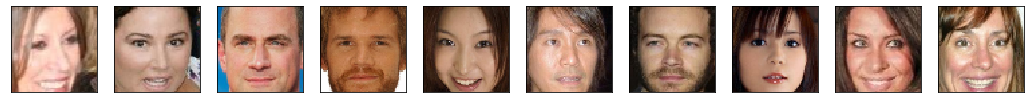

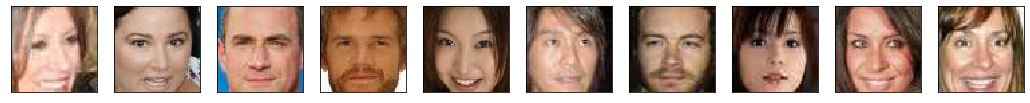

In [5]:
myplot(x_train[:10])
myplot(x_train_corrupt[:10])

In [13]:
rednet = REDNet()

opt = tf.keras.optimizers.Adam(lr=0.0001)
rednet.compile(loss='mean_squared_error', 
               optimizer=opt, 
               metrics=['accuracy', 'mse'])

decoded:  Tensor("relu_decoded_layer_1/Identity:0", shape=(?, 64, 64, 3), dtype=float32)


In [ ]:
rednet.fit(x_train, x_train, #_corrupt, x_train,
           epochs=1,
           batch_size=500,
           shuffle=True,
           validation_data=(x_test, x_test))

W0802 04:13:53.920834  3272 deprecation.py:323] From C:\Users\Patrick\Anaconda3\envs\tf_1_14\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 43965 samples, validate on 10992 samples
 7000/43965 [===>..........................] - ETA: 42:39 - loss: 4.5762e-04 - acc: 0.9700 - mean_squared_error: 4.5762e-04